In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
%matplotlib inline

In [2]:
feat = pd.read_csv('spam.csv', encoding='latin-1')
feat.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Now drop "unnamed" columns and rename v1 and v2 to "label" and "message"

In [3]:
feat = feat.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
feat = feat.rename(columns = {'v1':'label','v2':'message'})

Let's look into our data

In [4]:
feat.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Intresting that "Sorry, I'll call later" appears only 30 times here =)

Now let's creating new feature "message length" and plot it to see if it's of any interest

In [5]:
feat['length'] = feat['message'].apply(len)
feat.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [6]:
features = feat.copy()
features = features.drop('message',axis='columns')
features.head()

,label,length
0,ham,111
1,ham,29
2,spam,155
3,ham,49
4,ham,61


C:\Users\DELL\AppData\Local\Temp\ipykernel_21548\4158512335.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-bright')


array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

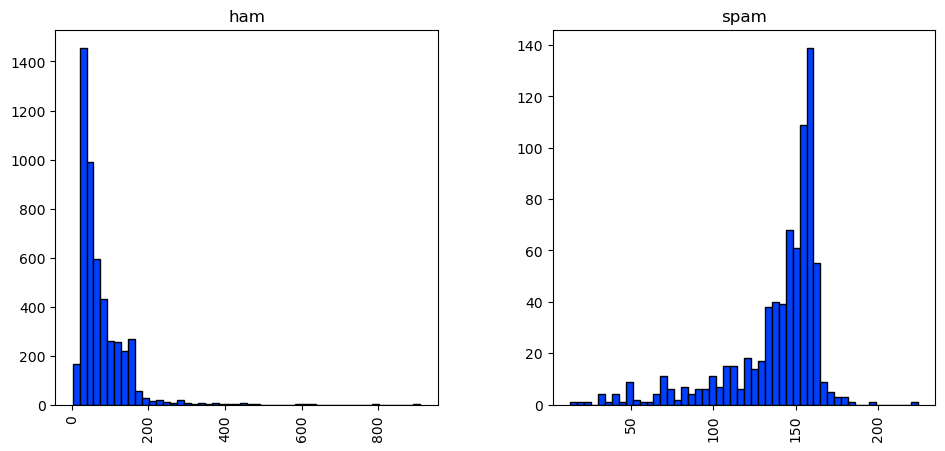

In [7]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
features.hist(column='length', by='label', bins=50,figsize=(11,5))

Looks like the lengthy is the message, more likely it is a spam. Let's not forget this

### Text processing and vectorizing our meddages

Let's create new data frame. We'll need a copy later on

In [8]:
features

,label,length
0,ham,111
1,ham,29
2,spam,155
3,ham,49
4,ham,61
...,...,...
5567,spam,161
5568,ham,37
5569,ham,57
5570,ham,125


In [9]:
text_feat = features['length'].copy()
text_lbl = features['label'].copy()

###  Classifiers and predictions

Now define our tex precessing function. It will remove any punctuation and stopwords aswell.

Now let's import bunch of classifiers, initialize them and make a dictionary to itereate through

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

First of all let's split our features to test and train set

In [11]:
features_train, features_test, labels_train, labels_test = train_test_split(text_feat, text_lbl, test_size=0.3, random_state=111)

In [12]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

Parametres are based on notebook:
[Spam detection Classifiers hyperparameter tuning][1]


  [1]: https://www.kaggle.com/muzzzdy/d/uciml/sms-spam-collection-dataset/spam-detection-classifiers-hyperparameter-tuning/

In [13]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

Let's make functions to fit our classifiers and make predictions

In [14]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(np.array(feature_train).reshape(-1,1), np.array(labels_train).reshape(-1,1))

In [15]:
def predict_labels(clf, features):
    return (clf.predict(np.array(features).reshape(-1,1)))

In [16]:
print(clfs.items())

dict_items([('SVC', SVC(gamma=1.0, kernel='sigmoid')), ('KN', KNeighborsClassifier(n_neighbors=49)), ('NB', MultinomialNB(alpha=0.2)), ('DT', DecisionTreeClassifier(min_samples_split=7, random_state=111)), ('LR', LogisticRegression(penalty='l1', solver='liblinear')), ('RF', RandomForestClassifier(n_estimators=31, random_state=111)), ('AdaBoost', AdaBoostClassifier(n_estimators=62, random_state=111)), ('BgC', BaggingClassifier(n_estimators=9, random_state=111)), ('ETC', ExtraTreesClassifier(n_estimators=9, random_state=111))])


Now iterate through classifiers and save the results

In [17]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

C:\Users\DELL\anaconda3\envs\aiml\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\envs\aiml\lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\DELL\anaconda3\envs\aiml\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\envs\aiml\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please c

In [18]:
df1 = pd.DataFrame(pred_scores)
temp = np.array(df1[1])
temp2=[]
for i in temp:
    temp2.append(i[0])
temp2

[0.861244019138756,
 0.8726076555023924,
 0.861244019138756,
 0.868421052631579,
 0.8504784688995215,
 0.8690191387559809,
 0.8767942583732058,
 0.8690191387559809,
 0.868421052631579]

In [19]:
df1[2] = temp2
df1.head()

,0,1,2
0,SVC,[0.861244019138756],0.861244
1,KN,[0.8726076555023924],0.872608
2,NB,[0.861244019138756],0.861244
3,DT,[0.868421052631579],0.868421
4,LR,[0.8504784688995215],0.850478


In [20]:
df = df1.drop(1,axis='columns')
df.head()

,0,2
0,SVC,0.861244
1,KN,0.872608
2,NB,0.861244
3,DT,0.868421
4,LR,0.850478


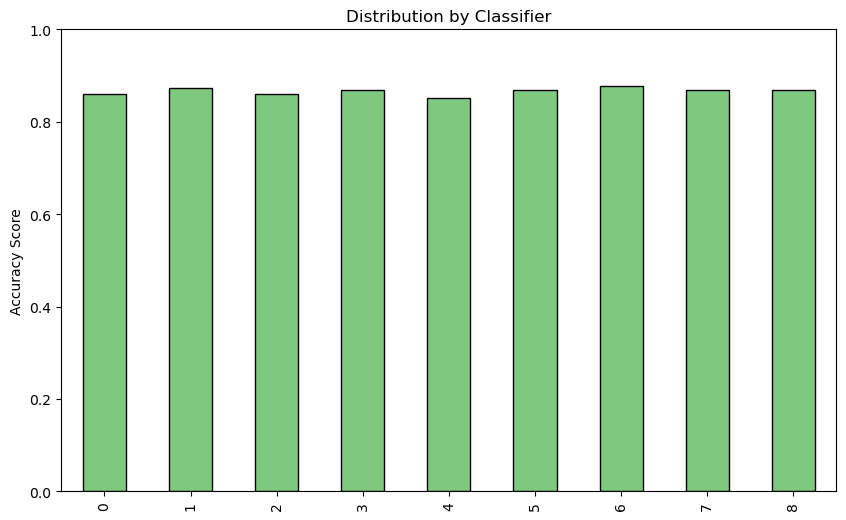

In [21]:
df[2].plot.bar(ylim=(0,1),figsize=(10,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.show()

In [22]:
features_train, features_test, labels_train, labels_test = train_test_split(text_feat, text_lbl, test_size=0.3, random_state=111)

In [23]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

C:\Users\DELL\anaconda3\envs\aiml\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\envs\aiml\lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\DELL\anaconda3\envs\aiml\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\envs\aiml\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please c

In [24]:
df2 = pd.DataFrame(pred_scores)
temp = np.array(df2[1])
temp2=[]
for i in temp:
    temp2.append(i[0])
temp2

[0.861244019138756,
 0.8726076555023924,
 0.861244019138756,
 0.868421052631579,
 0.8504784688995215,
 0.8690191387559809,
 0.8767942583732058,
 0.8690191387559809,
 0.868421052631579]

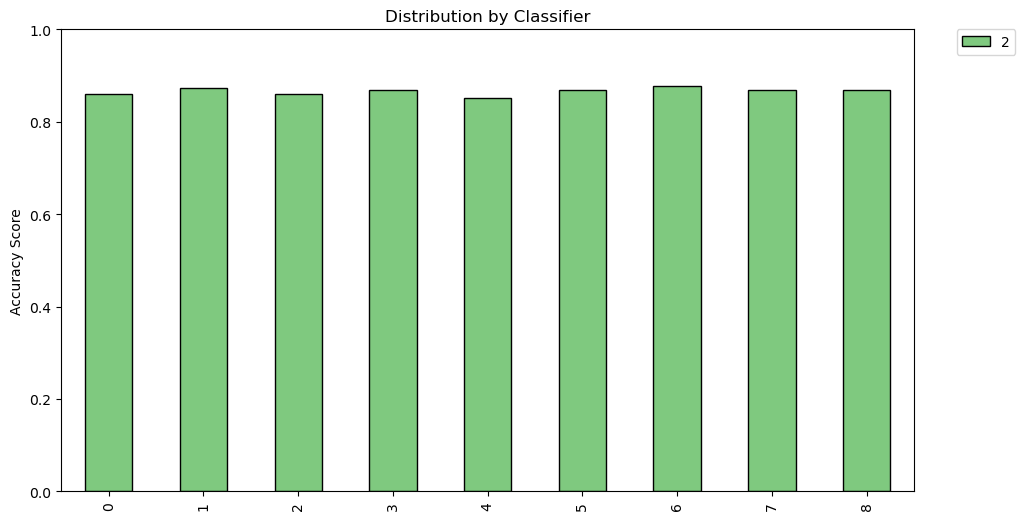

In [25]:
df.plot(kind='bar', ylim=(0.0,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Looks like mostly the same . Ensemble classifiers doing a little bit better, Lets try NB, if we still got the lead!!